# Census Income Prediction using PySpark

The [Census-Income (KDD) Dataset](https://archive.ics.uci.edu/dataset/117/census+income+kdd) is a dataset containing census data extracted from 1994 to 1995 by the US Census Bureau. It contains 299285 instances.
The target of the project is to correctly predict the income binary variable, where the values are "above 50.000$" and "below 50.000$".

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Census Income Data Analysis") \
    .getOrCreate()

23/12/18 12:24:01 WARN Utils: Your hostname, francesco-PC resolves to a loopback address: 127.0.1.1; using 192.168.1.211 instead (on interface enp4s0)
23/12/18 12:24:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/18 12:24:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load data
The dataset is already split into train and test. After defining the schema of the dataset, I will proceed to define the categorical variables within the dataset.

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

schema = StructType([
    StructField('age',IntegerType(), True),
    StructField('class_of_worker', StringType (), True),
    StructField('industry_code', DoubleType (), True),
    StructField('occupation_code', DoubleType (), True),
    StructField('education', StringType (), True),
    StructField('wage_per_hour', DoubleType (), True),
    StructField('enrolled_in_edu_inst_last_wk', StringType (), True),
    StructField('marital_status', StringType (), True),
    StructField('major_industry_code', StringType (), True),
    StructField('major_occupation_code', StringType (), True),
    StructField('race', StringType (), True),
    StructField('hispanic_Origin', StringType (), True),
    StructField('sex', StringType (), True),
    StructField('member_of_a_labor_union', StringType (), True),
    StructField('reason_for_unemployment', StringType (), True),
    StructField('full_or_part_time_employment_stat', StringType (), True),
    StructField('capital_gains', DoubleType (), True),
    StructField('capital_losses', DoubleType (), True),
    StructField('divdends_from_stocks', DoubleType (), True),
    StructField('tax_filer_status', StringType (), True),
    StructField('region_of_previous_residence', StringType (), True),
    StructField('state_of_previous_residence', StringType (), True),
    StructField('detailed_household_and_family_stat', StringType (), True),
    StructField('detailed_household_summary_in_household', StringType (), True),
    StructField('instance_weight', DoubleType (), True),
    StructField('migration_code_change_in_msa', StringType (), True),
    StructField('migration_code_change_in_reg', StringType (), True),
    StructField('migration_code_move_within_reg', StringType (), True),
    StructField('live_in_this_house_1_year_ago', StringType (), True),
    StructField('migration_prev_res_in_sunbelt', StringType (), True),
    StructField('num_persons_worked_for_employer', DoubleType (), True),
    StructField('family_members_under_18', StringType (), True),
    StructField('country_of_birth_father', StringType (), True),
    StructField('country_of_birth_mother', StringType (), True),
    StructField('country_of_birth_self', StringType (), True),
    StructField('citizenship', StringType (), True),
    StructField('own_business_or_self_employed', DoubleType (), True),
    StructField('fill_inc_questionnaire_for_veterans_admin', StringType (), True),
    StructField('veterans_benefits', DoubleType (), True),
    StructField('weeks_worked_in_year', DoubleType (), True),
    StructField('year', DoubleType (), True),
    StructField('income', StringType (), True),
])


In [3]:
# Load the .data file
data_path = "data/census-income.data"
df_train = spark.read.csv(data_path, schema=schema, header=False)

# Load the .test file
test_path = "data/census-income.test"
df_test = spark.read.csv(test_path, schema=schema, header=False)

# drop instance weight column ( suggested in dataset notes)
df_train = df_train.drop('instance_weight')
df_test = df_test.drop('instancee_weight')

categorical_cols = ['class_of_worker', 'education','enrolled_in_edu_inst_last_wk','marital_status', 'major_industry_code', 'major_occupation_code','race', 'hispanic_Origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment','full_or_part_time_employment_stat','tax_filer_status','region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt','family_members_under_18','country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','fill_inc_questionnaire_for_veterans_admin']
numerical_cols = ['age', 'industry_code', 'occupation_code', 'wage_per_hour', 'capital_gains', 'capital_losses', 'divdends_from_stocks', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veterans_benefits', 'weeks_worked_in_year', 'year']

# Print first 5 rows
df_train.show(5, truncate=False, vertical=True)

23/12/18 12:24:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------------------------------------------------------------
 age                                       | 73                                        
 class_of_worker                           |  Not in universe                          
 industry_code                             | 0.0                                       
 occupation_code                           | 0.0                                       
 education                                 |  High school graduate                     
 wage_per_hour                             | 0.0                                       
 enrolled_in_edu_inst_last_wk              |  Not in universe                          
 marital_status                            |  Widowed                                  
 major_industry_code                       |  Not in universe or children              
 major_occupation_code                     |  Not in universe                          
 race                           

In [4]:
df_train.printSchema()

root
 |-- age: integer (nullable = true)
 |-- class_of_worker: string (nullable = true)
 |-- industry_code: double (nullable = true)
 |-- occupation_code: double (nullable = true)
 |-- education: string (nullable = true)
 |-- wage_per_hour: double (nullable = true)
 |-- enrolled_in_edu_inst_last_wk: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- major_industry_code: string (nullable = true)
 |-- major_occupation_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- hispanic_Origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member_of_a_labor_union: string (nullable = true)
 |-- reason_for_unemployment: string (nullable = true)
 |-- full_or_part_time_employment_stat: string (nullable = true)
 |-- capital_gains: double (nullable = true)
 |-- capital_losses: double (nullable = true)
 |-- divdends_from_stocks: double (nullable = true)
 |-- tax_filer_status: string (nullable = true)
 |-- region_of_previous_residence: strin

In [5]:
print(f'The train dataset has {df_train.count()} rows and {len(df_train.columns)} columns')

The train dataset has 199523 rows and 41 columns


# Exploratory Data Analysis

For simplicity reasons, EDA visualization will be performed using a pandas dataframe instead of the sparks one

In [6]:
df_train_pd = df_train.toPandas()

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'industry_code'}>,
        <Axes: title={'center': 'occupation_code'}>],
       [<Axes: title={'center': 'wage_per_hour'}>,
        <Axes: title={'center': 'capital_gains'}>,
        <Axes: title={'center': 'capital_losses'}>],
       [<Axes: title={'center': 'divdends_from_stocks'}>,
        <Axes: title={'center': 'num_persons_worked_for_employer'}>,
        <Axes: title={'center': 'own_business_or_self_employed'}>],
       [<Axes: title={'center': 'veterans_benefits'}>,
        <Axes: title={'center': 'weeks_worked_in_year'}>,
        <Axes: title={'center': 'year'}>]], dtype=object)

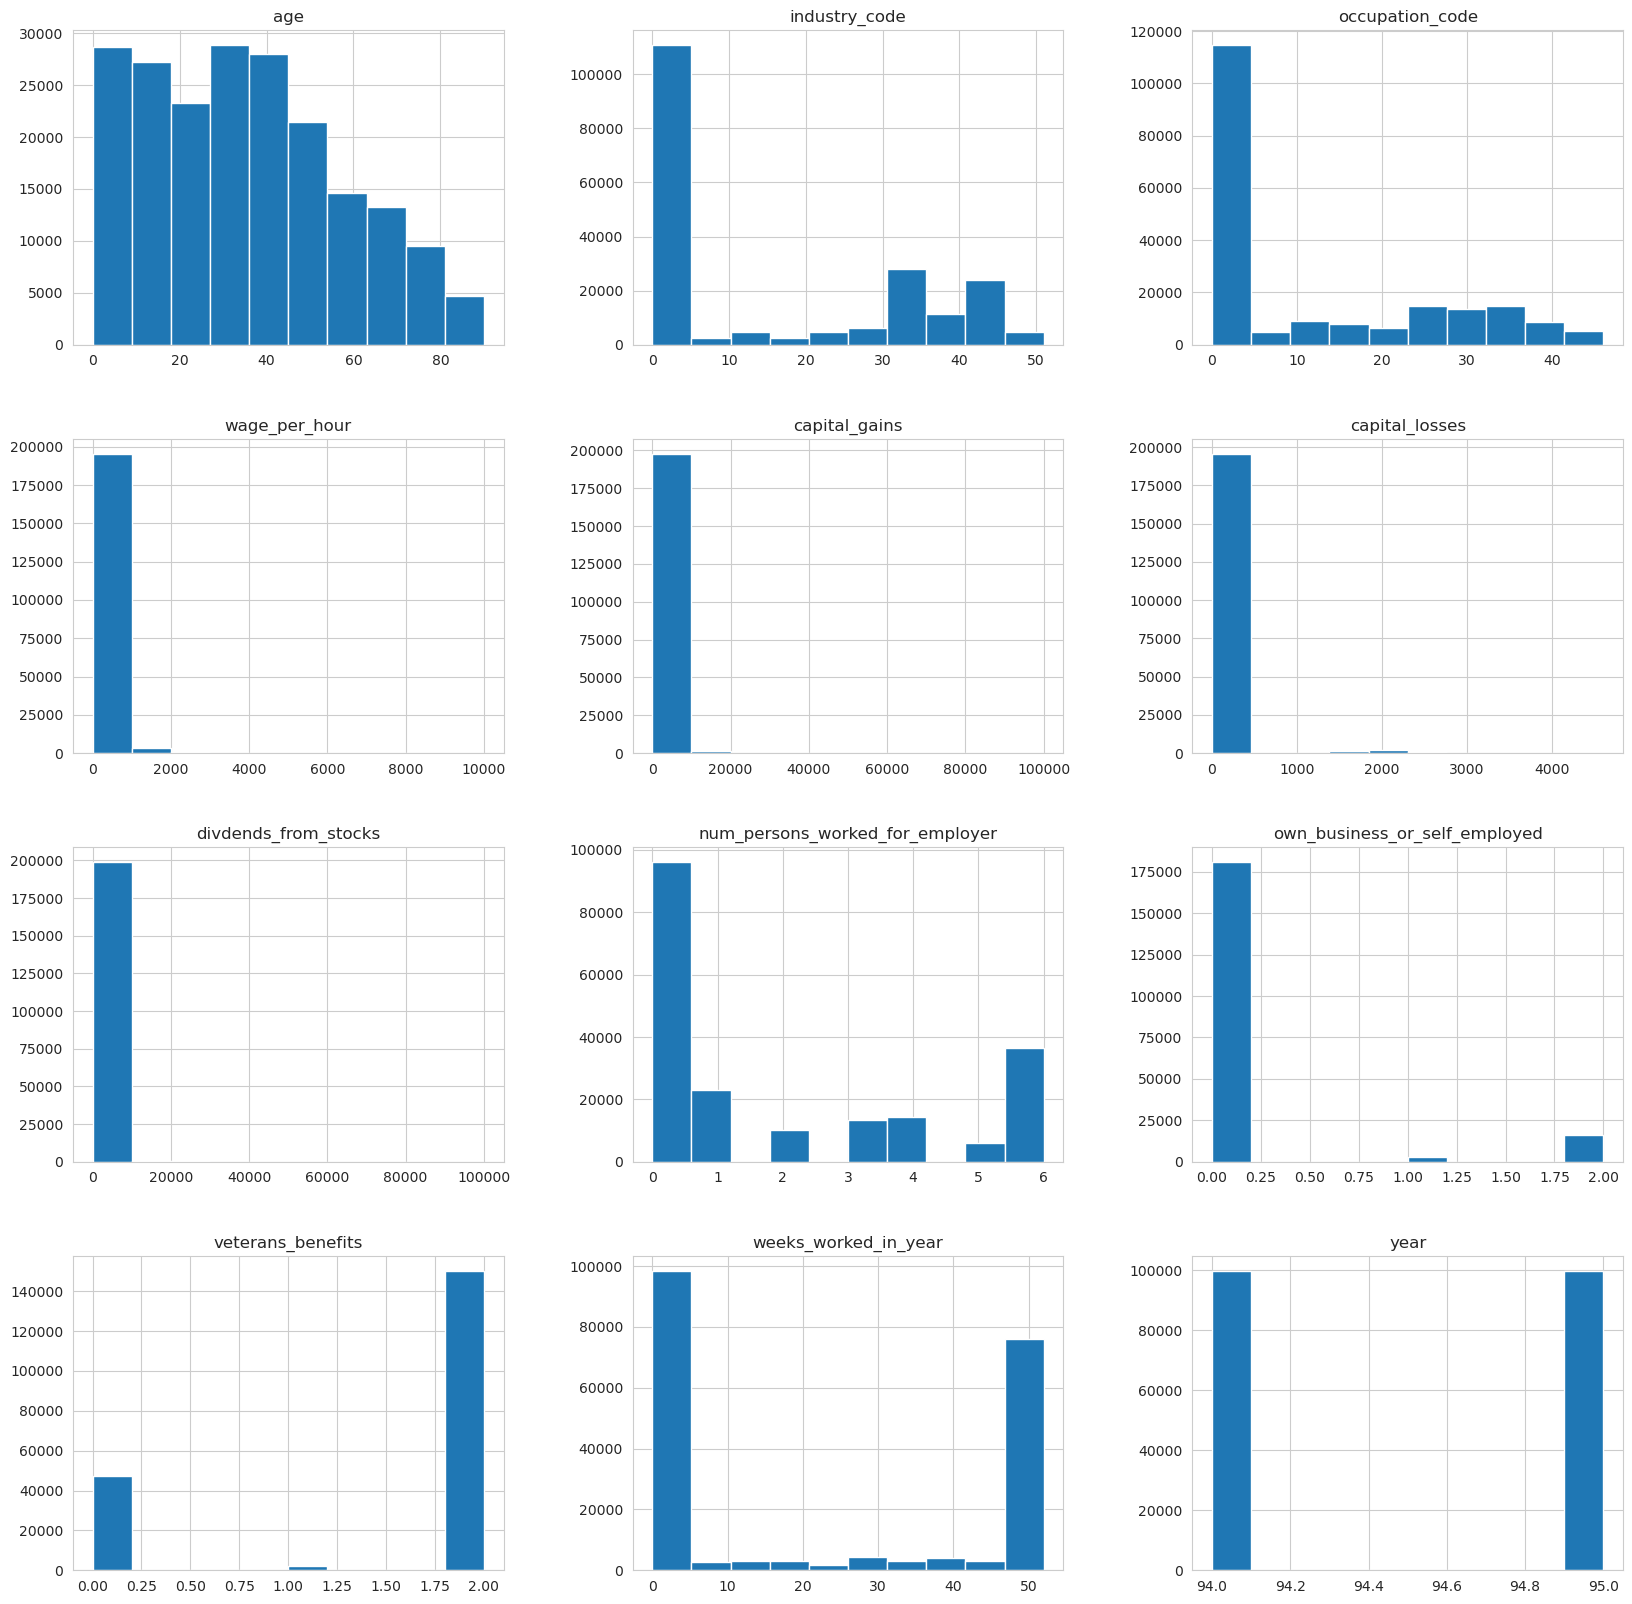

In [7]:
df_train_pd.hist(bins=10, figsize=(20,20))

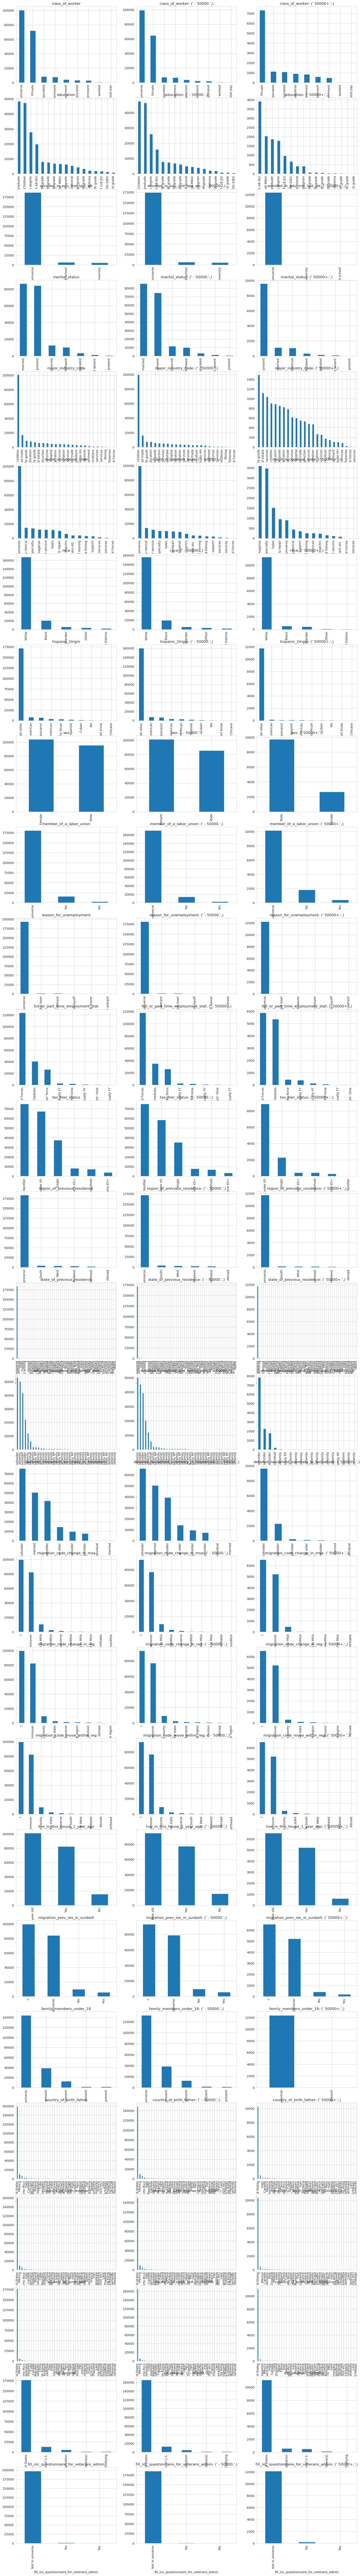

In [8]:
# get categorical and boolean features
cat_bool_col = [col[0] for col in df_train.dtypes if col[1] == 'string' and col[0] != 'income']

# group by values by outcome
train_set_pd_grouped = dict(list(df_train_pd.groupby(['income'])))
classes = list(train_set_pd_grouped.keys())

# create a one large plot
fig, ax = plt.subplots(len(cat_bool_col), 3, figsize=(20,150))

# for each variable add 3 plots
for num_var, var in enumerate(cat_bool_col):
    df_train_pd[var].value_counts().plot(kind="bar", ax=ax[num_var][0], title=var)
    for num_outcome, outcome in enumerate(classes):
        train_set_pd_grouped[outcome][var].value_counts().plot(kind="bar", ax=ax[num_var][1 + num_outcome], 
                                                               title='{}: {}'.format(var, outcome))

plt.show()

We can see how some of these variables have a high intra-class variance and not a high significance, for instance `hispanic_origin` or `reason_for_unemployment`. We will thus further clean the dataset.

In [9]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

mapping = {' - 50000.': '0',' 50000+.': '1'}


df_train = df_train.replace(to_replace=mapping, subset=['income'])
df_train = df_train.withColumn('income', df_train['income'].cast(IntegerType()))

df_test = df_test.replace(to_replace=mapping, subset=['income'])
df_test = df_test.withColumn('income', df_test['income'].cast(IntegerType()))

df_train.select('income').distinct().show()

+------+
|income|
+------+
|     1|
|     0|
+------+


## Dimensionality reduction
As the previous plots suggest, many variables are extremely unbalanced and don't provide much information. Two possible approaches to remove non-relevant variables are correlation with the target variable or PCA. Of course, none of the two is suited for categorical data, and as we saw the dataset contains a relevant number of categorical variables. Thus, we will use correlation for numerical data and manual selection for categorical columns, eventually after binning to more representative categories.

In [10]:
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

cm = correlation_matrix(df_train, numerical_cols + ['income'])
cm['income'].sort_values(ascending=False)

income                             1.000000
weeks_worked_in_year               0.262316
capital_gains                      0.240725
num_persons_worked_for_employer    0.222684
industry_code                      0.196190
divdends_from_stocks               0.175779
capital_losses                     0.147417
veterans_benefits                  0.140930
age                                0.135720
own_business_or_self_employed      0.040473
wage_per_hour                      0.024528
year                               0.014794
occupation_code                    0.013414
Name: income, dtype: float64

In [11]:
columns_to_drop = ['country_of_birth_father', 'country_of_birth_mother', 'citizenship', 'hispanic_Origin', 'fill_inc_questionnaire_for_veterans_admin', 'state_of_previous_residence', 'enrolled_in_edu_inst_last_wk', 'reason_for_unemployment', 'region_of_previous_residence']
df_train = df_train.drop(*columns_to_drop)
df_test = df_test.drop(*columns_to_drop)

for c in columns_to_drop:
    categorical_cols.remove(c)
    
categorical_cols

['class_of_worker',
 'education',
 'marital_status',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'sex',
 'member_of_a_labor_union',
 'full_or_part_time_employment_stat',
 'tax_filer_status',
 'detailed_household_and_family_stat',
 'detailed_household_summary_in_household',
 'migration_code_change_in_msa',
 'migration_code_change_in_reg',
 'migration_code_move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 'country_of_birth_self']

In [12]:
mappings = dict()

In [13]:
df_train.select('education').distinct().show(truncate=False)

+---------------------------------------+
|education                              |
+---------------------------------------+
| 10th grade                            |
| Some college but no degree            |
| Doctorate degree(PhD EdD)             |
| Less than 1st grade                   |
| 12th grade no diploma                 |
| Associates degree-academic program    |
| Bachelors degree(BA AB BS)            |
| High school graduate                  |
| Prof school degree (MD DDS DVM LLB JD)|
| 9th grade                             |
| Associates degree-occup /vocational   |
| 11th grade                            |
| Children                              |
| Masters degree(MA MS MEng MEd MSW MBA)|
| 5th or 6th grade                      |
| 1st 2nd 3rd or 4th grade              |
| 7th and 8th grade                     |
+---------------------------------------+


In [14]:
mappings['education'] = {
    '10th grade': 'no_diploma',
    'Some college but no degree': 'diploma',
    'Doctorate degree(PhD EdD)': 'phd',
    'Less than 1st grade': 'no_diploma',
    '12th grade no diploma': 'no_diploma',
    'Associates degree-academic program': 'degree',
    'Bachelors degree(BA AB BS)': 'degree',
    'High school graduate': 'diploma',
    'Prof school degree (MD DDS DVM LLB JD)': 'degree',
    '9th grade': 'no_diploma',
    'Associates degree-occup /vocational': 'degree',
    '11th grade': 'no_diploma',
    'Children': 'no_diploma',
    'Masters degree(MA MS MEng MEd MSW MBA)': 'degree',
    '5th or 6th grade': 'no_diploma',
    '1st 2nd 3rd or 4th grade': 'no_diploma',
    '7th and 8th grade': 'no_diploma',
}

In [15]:
df_train.select('country_of_birth_self').distinct().show(truncate=False, n = 50)

+-----------------------------+
|country_of_birth_self        |
+-----------------------------+
| Dominican-Republic          |
| Ireland                     |
| Cuba                        |
| Guatemala                   |
| Iran                        |
| Panama                      |
| El-Salvador                 |
| Taiwan                      |
| Hong Kong                   |
| United-States               |
| Japan                       |
| Nicaragua                   |
| Canada                      |
| Cambodia                    |
| Laos                        |
| Germany                     |
| South Korea                 |
| Trinadad&Tobago             |
| Peru                        |
| Ecuador                     |
| Yugoslavia                  |
| Vietnam                     |
| Philippines                 |
| Honduras                    |
| Jamaica                     |
| England                     |
| India                       |
| Puerto-Rico                 |
| Holand

In [16]:
mappings['country_of_birth_self'] = {
    'Dominican-Republic': 'CAM',
    'Trinadad&Tobago': 'CAM',
    'Ireland': 'EU',
    'England': 'EU',
    'Poland': 'EU',
    'Scotland': 'EU',
    'Hungary': 'EU',
    'France': 'EU',
    'Germany': 'EU',
    'Portugal': 'EU',
    'Holand-Netherlands': 'EU',
    'Greece': 'EU',
    'Yugoslavia': 'EU',
    'Italy': 'EU',
    'Cuba': 'CAM',
    'Haiti': 'CAM',
    'Honduras': 'CAM',
    'Nicaragua': 'CAM',
    'Mexico': 'CAM',
    'Jamaica': 'CAM',
    'Puerto-Rico': 'CAM',
    'Guatemala': 'CAM',
    'Iran': 'AS',
    'Vietnam': 'AS',
    'Thailand': 'AS',
    'China': 'AS',
    'India': 'AS',
    'Japan': 'AS',
    'Cambodia': 'AS',
    'Philippines': 'AS',
    'Laos': 'AS',
    'Hong Kong': 'AS',
    'Taiwan': 'AS',
    'Outlying-U S (Guam USVI etc)': 'OC',
    'South Korea': 'AS',
    'Panama': 'CAM',
    'El-Salvador': 'CAM',
    'United-States': 'NAM',
    'Canada': 'NAM',
    'Peru': 'SAM',
    'Ecuador': 'SAM',
    'Columbia': 'SAM',
}

In [17]:
mappings

{'education': {'10th grade': 'no_diploma',
  'Some college but no degree': 'diploma',
  'Doctorate degree(PhD EdD)': 'phd',
  'Less than 1st grade': 'no_diploma',
  '12th grade no diploma': 'no_diploma',
  'Associates degree-academic program': 'degree',
  'Bachelors degree(BA AB BS)': 'degree',
  'High school graduate': 'diploma',
  'Prof school degree (MD DDS DVM LLB JD)': 'degree',
  '9th grade': 'no_diploma',
  'Associates degree-occup /vocational': 'degree',
  '11th grade': 'no_diploma',
  'Children': 'no_diploma',
  'Masters degree(MA MS MEng MEd MSW MBA)': 'degree',
  '5th or 6th grade': 'no_diploma',
  '1st 2nd 3rd or 4th grade': 'no_diploma',
  '7th and 8th grade': 'no_diploma'},
 'country_of_birth_self': {'Dominican-Republic': 'CAM',
  'Trinadad&Tobago': 'CAM',
  'Ireland': 'EU',
  'England': 'EU',
  'Poland': 'EU',
  'Scotland': 'EU',
  'Hungary': 'EU',
  'France': 'EU',
  'Germany': 'EU',
  'Portugal': 'EU',
  'Holand-Netherlands': 'EU',
  'Greece': 'EU',
  'Yugoslavia': 'EU

In [18]:
from pyspark.sql import functions as f

for column in mappings:
    print(column)
    df_train = df_train.withColumn(column, f.trim(f.col(column))).replace(to_replace=mappings[column], subset=[column])
    df_test = df_test.replace(to_replace=mappings[column], subset=[column])

education
country_of_birth_self


In [19]:
df_train.select('country_of_birth_self').distinct().show(truncate=False)

+---------------------+
|country_of_birth_self|
+---------------------+
|CAM                  |
|NAM                  |
|AS                   |
|?                    |
|OC                   |
|EU                   |
|SAM                  |
+---------------------+


## Pipeline creation

In [20]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"-index") for column in categorical_cols]

assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCol="cat_features")

In [21]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + [assembler])

train = pipeline.fit(df_train).transform(df_train)

test = pipeline.fit(df_test).transform(df_test)

In [22]:
assembler = VectorAssembler(inputCols=['cat_features', *numerical_cols],outputCol='features')

train = assembler.transform(train)
test = assembler.transform(test)

In [23]:
train = train.withColumnRenamed('income', 'label')
test = test.withColumnRenamed('income', 'label')
train.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 12382|
|    0|187141|
+-----+------+


We can see how to income label is extremely unbalanced: we will first try to develop a model without balancing the classes, then we will balance the class and inspect the differences.

## Model 1: Random Forest Classifier
### Unbalanced Case

In [24]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [26]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

param_grid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5])
               .addGrid(rf.maxBins, [51])
               .addGrid(rf.numTrees, [10, 20, 50])
             .build())

               
cross_validator = CrossValidator(estimator = rf, estimatorParamMaps = param_grid, evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"), numFolds = 5)

cv_model = cross_validator.fit(train)

In [27]:
# Make predictions on the test data
predictions = cv_model.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

AUC-ROC: 0.9407
Accuracy: 0.9407
Precision: 0.9371
Recall: 0.9407


### Balanced Case

In [28]:
from pyspark.sql.functions import col, explode, array, lit

minor_df = train.filter(col("income") == 1)
major_df = train.filter(col("income") == 0)
ratio = int(major_df.count()/minor_df.count())

### OVERSAMPLIJNG
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows
train_balanced = major_df.unionAll(oversampled_df)

### UNDERSAMPLING
# sampled_majority_df = major_df.sample(False, 1/ratio)
# train = sampled_majority_df.unionAll(minor_df)
train_balanced.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    0|187141|
|    1|185730|
+-----+------+


In [29]:
cv_model_balanced = cross_validator.fit(train_balanced)

# Make predictions on the test data
predictions = cv_model_balanced.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

AUC-ROC: 0.8069
Accuracy: 0.8069
Precision: 0.9446
Recall: 0.8069


We can see how the results were actually better in the unbalanced case. We will stick to this approach for the next models too.

## Model 2: Logistic Regression

In [30]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

logistic_regression = LogisticRegression(featuresCol="features", labelCol="label")
model = logistic_regression.fit(train)

In [31]:
intercept = model.intercept

print("Intercept: {:.3f}".format(intercept))

Intercept: 7.945


In [32]:
predictions = model.transform(test)

# AUC-ROC
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

AUC-ROC: 0.8484
Accuracy: 0.8024
Precision: 0.9240
Recall: 0.8024


## Model 3: Support Vector Machines

In [33]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(labelCol="label", maxIter=50)
model = lsvc.fit(train)

predictions = model.transform(test)

In [34]:
evaluator=MulticlassClassificationEvaluator(metricName="accuracy")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

AUC-ROC: 0.9292
Accuracy: 0.9292
Precision: 0.9188
Recall: 0.9292


## Results

| Model               | Accuracy | AUC-ROC | Precision | Recall |
|---------------------|----------|---------|-----------|--------|
| RFC unbalanced      | 94.08%   | 94.08%  | 93.33%    | 94.08% |
| RFC balanced        | 80.28%   | 80.28%  | 94.43%    | 80.28% |
| Logistic Regression | 80.24%   | 84.84%  | 92.40%    | 80.24% |
| SVM                 | 92.92%   | 92.92%  | 91.88%    | 92.92% |

Accuracy

    Definition: Accuracy is the ratio of correctly predicted observations to the total observations. It's a useful metric when the classes in the dataset are nearly balanced.
    Interpretation:
        RFC unbalanced: Has the highest accuracy (94.08%), indicating it correctly predicted the majority of the outcomes. However, high accuracy in unbalanced datasets can sometimes be misleading.
        RFC balanced: Shows a significant drop in accuracy (80.28%) compared to the unbalanced version. This might be due to the balancing process which often makes the classification task more challenging.
        Logistic Regression: Similar accuracy to the balanced RFC.
        SVM: Second-highest accuracy (92.92%), indicating strong performance.

AUC-ROC

    Definition: Area Under the Receiver Operating Characteristic Curve (AUC-ROC) is a performance measurement for classification problems at various threshold settings. AUC measures the entire two-dimensional area underneath the entire ROC curve.
    Interpretation:
        RFC unbalanced: High AUC (94.08%), suggesting a good measure of separability between classes.
        RFC balanced: Lower AUC compared to the unbalanced model, which could be due to a harder classification task after balancing.
        Logistic Regression: Fairly good AUC (83.57%), but lower than both RFCs.
        SVM: High AUC, similar to its accuracy, indicating good class separability.

Precision

    Definition: Precision is the ratio of correctly predicted positive observations to the total predicted positives. High precision relates to a low false positive rate.
    Interpretation:
        RFC unbalanced and balanced: Both show high precision, with the balanced model slightly higher. This suggests that when they predict a positive class, they are often correct.
        Logistic Regression: High precision, indicating a low false positive rate.
        SVM: Slightly lower precision than others but still quite high.

Recall

    Definition: Recall (Sensitivity) is the ratio of correctly predicted positive observations to all observations in the actual class.
    Interpretation:
        RFC unbalanced: High recall, indicating it correctly identified most of the actual positives.
        RFC balanced: Recall drops significantly, which suggests it's missing more actual positives.
        Logistic Regression: Similar recall to the balanced RFC.
        SVM: High recall, indicating effective identification of actual positives.
        
Overall, the best model appears to be Random Forest with the unbalanced training set. Balancing the dataset allows for the highest precision overall, but the trade-off is still in favor of the unbalanced case, which performs even slightly better than the SVM model.

In [35]:
spark.stop()